In [1]:
DATA_PATH = "../data/preprocessed/engineering/marketing_campaign.csv" 

In [2]:
import pandas as pd
import numpy as np 
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import FunctionTransformer, RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from kneed import KneeLocator

from sklearn.ensemble import RandomForestClassifier





# set the max columns to none
pd.set_option('display.max_columns', None)

In [3]:
data = pd.read_parquet(DATA_PATH)
data.head()

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Education,Marital_Status,Income,Recency,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Customer_Tenure,total_Spent,total_purchases,Children,Income_per_Person,Campaign_Participation,Recency_Category,total_spent_per_time,total_purchases_per_time
0,6.455199,4.488636,6.304449,5.153292,4.488636,4.488636,1.386294,2.197225,2.397895,1.609438,2.079442,Graduation,Single,58138.0,58,0,0,0,0,0,0,1,57,664,31.378848,6.204558,0,29069.0,1,Recent,0.047257,0.009344
1,2.484907,0.693147,1.945910,1.098612,0.693147,1.945910,1.098612,0.693147,0.693147,1.098612,1.791759,Graduation,Single,46344.0,38,0,0,0,0,0,0,0,60,114,8.861634,2.484907,2,11586.0,0,Recent,0.077734,0.021797
2,6.056784,3.912023,4.852030,4.718499,3.091042,3.761200,0.693147,2.197225,1.098612,2.397895,1.609438,Graduation,Together,71613.0,26,0,0,0,0,0,0,0,49,313,26.391579,5.693732,0,35806.5,0,Very Recent,0.084318,0.018191
3,2.484907,1.609438,3.044522,2.397895,1.386294,1.791759,1.098612,1.098612,0.000000,1.609438,1.945910,Graduation,Together,26646.0,26,0,0,0,0,0,0,0,30,140,12.714816,2.708050,1,8882.0,0,Very Recent,0.090820,0.019343
4,5.159055,3.784190,4.779123,3.850148,3.332205,2.772589,1.791759,1.791759,1.386294,1.945910,1.791759,PhD,Married,58293.0,94,0,0,0,0,0,0,0,33,162,23.677309,5.123964,1,19431.0,0,Long Time,0.146156,0.031629


In [4]:
# encoding

features_to_encode = ['Education', 'Marital_Status', 'Recency_Category']

def one_hot_encode_features(df, features):
    # Perform one-hot encoding
    encoded_df = pd.get_dummies(df, columns=features, prefix='', prefix_sep='',dtype=int)
    
    # Remove spaces from column names and replace with underscores
    encoded_df.columns = encoded_df.columns.str.replace(' ', '_')
    
    return encoded_df

# Apply one-hot encoding
df = one_hot_encode_features(data, features_to_encode)


In [5]:
df.shape

(2023, 43)

In [6]:
df.head()

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Income,Recency,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Customer_Tenure,total_Spent,total_purchases,Children,Income_per_Person,Campaign_Participation,total_spent_per_time,total_purchases_per_time,2n_Cycle,Basic,Graduation,Master,PhD,Divorced,Married,Single,Together,Widow,Very_Recent,Recent,Not_Recent,Long_Time
0,6.455199,4.488636,6.304449,5.153292,4.488636,4.488636,1.386294,2.197225,2.397895,1.609438,2.079442,58138.0,58,0,0,0,0,0,0,1,57,664,31.378848,6.204558,0,29069.0,1,0.047257,0.009344,0,0,1,0,0,0,0,1,0,0,0,1,0,0
1,2.484907,0.693147,1.945910,1.098612,0.693147,1.945910,1.098612,0.693147,0.693147,1.098612,1.791759,46344.0,38,0,0,0,0,0,0,0,60,114,8.861634,2.484907,2,11586.0,0,0.077734,0.021797,0,0,1,0,0,0,0,1,0,0,0,1,0,0
2,6.056784,3.912023,4.852030,4.718499,3.091042,3.761200,0.693147,2.197225,1.098612,2.397895,1.609438,71613.0,26,0,0,0,0,0,0,0,49,313,26.391579,5.693732,0,35806.5,0,0.084318,0.018191,0,0,1,0,0,0,0,0,1,0,1,0,0,0
3,2.484907,1.609438,3.044522,2.397895,1.386294,1.791759,1.098612,1.098612,0.000000,1.609438,1.945910,26646.0,26,0,0,0,0,0,0,0,30,140,12.714816,2.708050,1,8882.0,0,0.090820,0.019343,0,0,1,0,0,0,0,0,1,0,1,0,0,0
4,5.159055,3.784190,4.779123,3.850148,3.332205,2.772589,1.791759,1.791759,1.386294,1.945910,1.791759,58293.0,94,0,0,0,0,0,0,0,33,162,23.677309,5.123964,1,19431.0,0,0.146156,0.031629,0,0,0,0,1,0,1,0,0,0,0,0,0,1


In [7]:
df.columns

Index(['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
       'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'Income', 'Recency', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response', 'Age', 'Customer_Tenure', 'total_Spent',
       'total_purchases', 'Children', 'Income_per_Person',
       'Campaign_Participation', 'total_spent_per_time',
       'total_purchases_per_time', '2n_Cycle', 'Basic', 'Graduation', 'Master',
       'PhD', 'Divorced', 'Married', 'Single', 'Together', 'Widow',
       'Very_Recent', 'Recent', 'Not_Recent', 'Long_Time'],
      dtype='object')

In [8]:
# selected features to do clustring on.
features = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts','MntSweetProducts', 'MntGoldProds','total_Spent','total_spent_per_time', # spend
            'NumDealsPurchases','NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases','NumWebVisitsMonth','total_purchases','total_purchases_per_time', # purchases channels
            'Income', 'Age','Income_per_Person','Children', # demographic
       'Very_Recent', 'Recent', 'Not_Recent', 'Long_Time', # recent
       '2n_Cycle', 'Basic', 'Graduation', 'Master','PhD', # education
       'Divorced', 'Married', 'Single', 'Together', 'Widow', # Marital_Status
       'Campaign_Participation','AcceptedCmp3', 'AcceptedCmp4','AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Response', # campaigns
       ]  

# Note: only two features i do not useed 'Complain' and 'Customer_Tenure'.

numeric_to_scale = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts','MntSweetProducts', 'MntGoldProds','total_Spent',
            'NumDealsPurchases','NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases','NumWebVisitsMonth','total_purchases',
            'Income', 'Age','Income_per_Person','total_spent_per_time','total_purchases_per_time'
          ]



# Prepare the data
X = df[features].copy()

# Standardize the features
scaler = StandardScaler()

combined_transformer = ColumnTransformer(
    transformers=[
        ('scale',scaler 
        , numeric_to_scale)
    ],
    remainder='passthrough'  # Leave other columns unchanged
)

X_scaled = combined_transformer.fit_transform(X)


In [9]:
# Get the feature names after transformation
transformed_features = numeric_to_scale + [col for col in features if col not in numeric_to_scale]

# Convert the scaled data back to a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=transformed_features)

print(X_scaled_df.shape)
X_scaled_df.head()

(2023, 40)


,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,total_Spent,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,total_purchases,Income,Age,Income_per_Person,total_spent_per_time,total_purchases_per_time,Children,Very_Recent,Recent,Not_Recent,Long_Time,2n_Cycle,Basic,Graduation,Master,PhD,Divorced,Married,Single,Together,Widow,Campaign_Participation,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response
0,0.980992,1.430831,1.396790,1.578342,1.406575,1.061891,1.587212,0.649610,1.278584,1.817670,-0.411194,0.705617,1.211833,0.312104,1.019470,0.846304,-0.151542,-0.159438,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-1.222665,-0.989562,-1.404876,-0.859794,-0.972549,-0.917585,-1.291075,0.030822,-1.427370,-0.411809,-1.479498,0.076110,-1.155687,-0.257614,1.276604,-0.692572,-0.113974,-0.092318,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.759857,1.063124,0.463176,1.316895,0.530522,0.495593,0.949709,-0.841312,1.278584,0.118460,1.237728,-0.322846,0.886698,0.963024,0.333779,1.439347,-0.105857,-0.111757,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.222665,-0.405241,-0.698689,-0.078517,-0.538064,-1.037589,-0.798538,0.030822,-0.697906,-1.318311,-0.411194,0.413423,-1.013658,-1.209141,-1.294738,-0.930582,-0.097842,-0.105546,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.261585,0.981604,0.416312,0.794743,0.681689,-0.274027,0.602754,1.521744,0.549121,0.494693,0.292479,0.076110,0.524046,0.319591,-1.037604,-0.002045,-0.029630,-0.039326,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


> negative values mean that : this value is far from the mean in the right direction.

In [10]:
# cluster on the PCA result and additional_features or  not.(doing PCA on the subset of the data)

# PCA class
class PCAProcessor:
    def __init__(self, n_components=2):
        self.n_components = n_components

    def fit_transform(self, data, feature_sets, additional_features=[]):
        """
        Perform PCA on each subset of features, combine the results with additional features.

        Parameters:
        - data: pandas DataFrame containing the features.
        - feature_sets: dict where keys are subset names and values are lists of feature names.
        - additional_features: list of feature names to be included without PCA.

        Returns:
        - combined_pca_df: pandas DataFrame with the combined PCA results and additional features.
        """
        pca_results = []
        column_names = []
        
        for subset_name, features in feature_sets.items():
            try:
                print(f"Performing PCA on {subset_name}...")
                pca = PCA(n_components=self.n_components)
                pca_result = pca.fit_transform(data[features])
                
                # Create column names for the PCA components
                component_names = [f"{subset_name}_PC{i+1}" for i in range(self.n_components)]
                
                # Append results and column names
                pca_results.append(pd.DataFrame(pca_result, columns=component_names))
                column_names.extend(component_names)
            except Exception as e:
                print(f"Error processing {subset_name}: {e}")
        
        # Combine all PCA results into a single DataFrame
        combined_pca_df = pd.concat(pca_results, axis=1)

        # Add additional features to the DataFrame
        if additional_features:
            additional_data = data[additional_features].reset_index(drop=True)
            combined_pca_df = pd.concat([combined_pca_df, additional_data], axis=1)
        
        return combined_pca_df

In [11]:

feature_sets = {
        'Spending Behavior': ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 
                              'MntSweetProducts', 'MntGoldProds', 'total_Spent','total_spent_per_time'],
        'Purchase Channels': ['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 
                              'NumStorePurchases', 'NumWebVisitsMonth', 'total_purchases','total_purchases_per_time'],
        'Demographic Information': ['Income', 'Age', 'Income_per_Person', 'Children'],
        'Recent Activity': ['Very_Recent', 'Recent', 'Not_Recent', 'Long_Time', 'Customer_Tenure'],
        'Education': ['2n_Cycle', 'Basic', 'Graduation', 'Master', 'PhD'],
        'Marital Status': ['Divorced', 'Married', 'Single', 'Together', 'Widow'],
        'Campaign Participation': ['Campaign_Participation', 'AcceptedCmp3', 'AcceptedCmp4',
                                   'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Response']
        
}
    
pca_processor = PCAProcessor(n_components=2)
X_pca_df = pca_processor.fit_transform(X_scaled_df, feature_sets)
    
print(f"Combined PCA DataFrame shape: {X_pca_df.shape}")

X_pca_df.head()

Performing PCA on Spending Behavior...
Performing PCA on Purchase Channels...
Performing PCA on Demographic Information...
Performing PCA on Recent Activity...
Error processing Recent Activity: "['Customer_Tenure'] not in index"
Performing PCA on Education...
Performing PCA on Marital Status...
Performing PCA on Campaign Participation...
Combined PCA DataFrame shape: (2023, 12)


,Spending Behavior_PC1,Spending Behavior_PC2,Purchase Channels_PC1,Purchase Channels_PC2,Demographic Information_PC1,Demographic Information_PC2,Education_PC1,Education_PC2,Marital Status_PC1,Marital Status_PC2,Campaign Participation_PC1,Campaign Participation_PC2
0,-3.583867,-0.279611,-1.677111,-1.245596,1.256627,-0.581702,-0.571390,-0.055685,-0.421097,0.782964,0.685750,-0.511488
1,2.914869,0.005068,2.134488,0.489192,-0.736098,-1.599701,-0.571390,-0.055685,-0.421097,0.782964,-0.501841,0.023315
2,-2.105573,-0.169035,-1.707104,0.252302,1.951288,0.135933,-0.571390,-0.055685,-0.603078,-0.618522,-0.501841,0.023315
3,1.784358,-0.007373,1.784384,-0.077041,-1.651039,1.112165,-0.571390,-0.055685,-0.603078,-0.618522,-0.501841,0.023315
4,-1.340119,-0.058688,-0.916773,-1.321974,0.003023,0.960606,0.738701,-0.578293,0.698266,-0.070937,-0.501841,0.023315


### look at the data and features with PCA and without it.
 - what will we use ? X_scaled_df or X_pca_df ?
    - We test and visualize to make decisions.


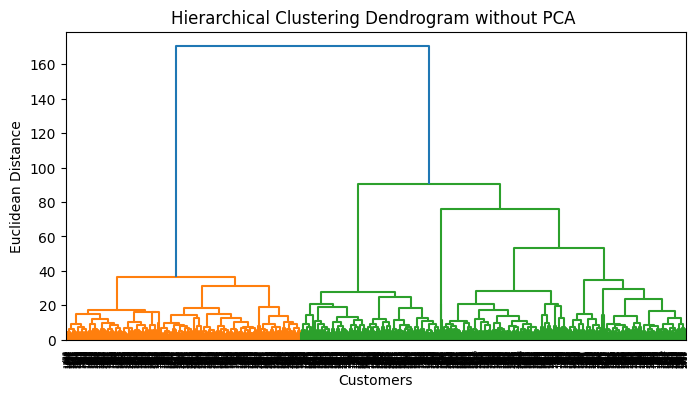

In [12]:
# Perform Hierarchical Clustering using the 'ward' linkage method

linked = linkage(X_scaled_df, method='ward')

# Plot the Dendrogram
plt.figure(figsize=(8, 4))
dendrogram(linked,
           orientation='top',
           distance_sort='ascending',
           show_leaf_counts=False)
plt.title('Hierarchical Clustering Dendrogram without PCA ')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distance')
plt.show()

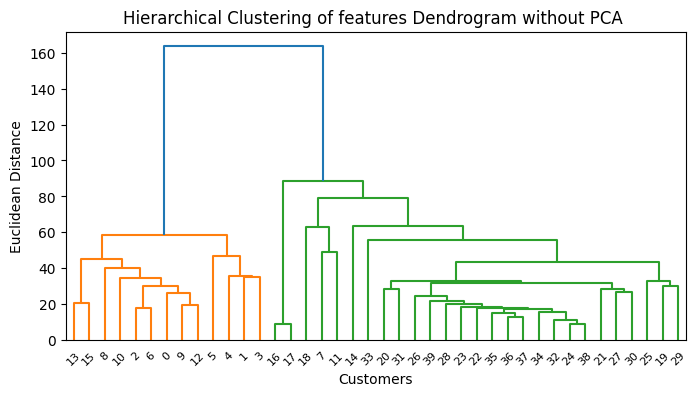

In [13]:

linked = linkage(X_scaled_df.T, method='ward')

# Plot the Dendrogram
plt.figure(figsize=(8, 4))
dendrogram(linked,
           orientation='top',
           distance_sort='ascending')
plt.title('Hierarchical Clustering of features Dendrogram without PCA ')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distance')
plt.show()

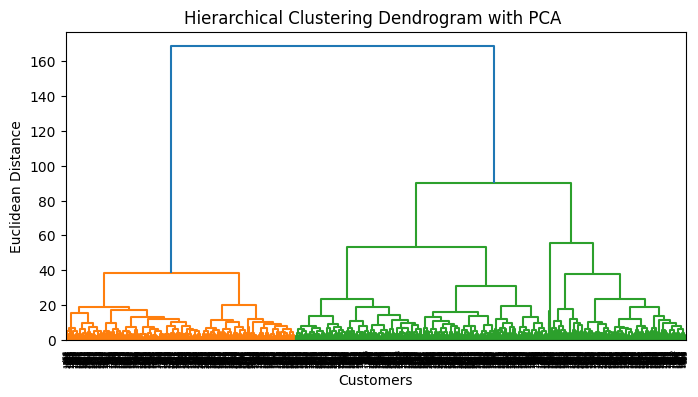

In [14]:

linked = linkage(X_pca_df, method='ward')

# Plot the Dendrogram
plt.figure(figsize=(8, 4))
dendrogram(linked,
           orientation='top',
           distance_sort='ascending',
           show_leaf_counts=False)
plt.title('Hierarchical Clustering Dendrogram with PCA ')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distance')
plt.show()

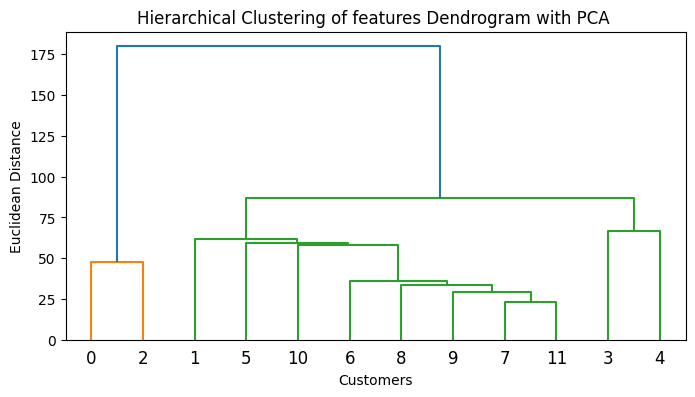

In [15]:
# look at the features 
# Perform Hierarchical Clustering using the 'ward' linkage method

linked = linkage(X_pca_df.T, method='ward')

# Plot the Dendrogram
plt.figure(figsize=(8, 4))
dendrogram(linked,
           orientation='top',
           distance_sort='ascending',
           show_leaf_counts=False)
plt.title('Hierarchical Clustering of features Dendrogram with PCA ')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distance')
plt.show()

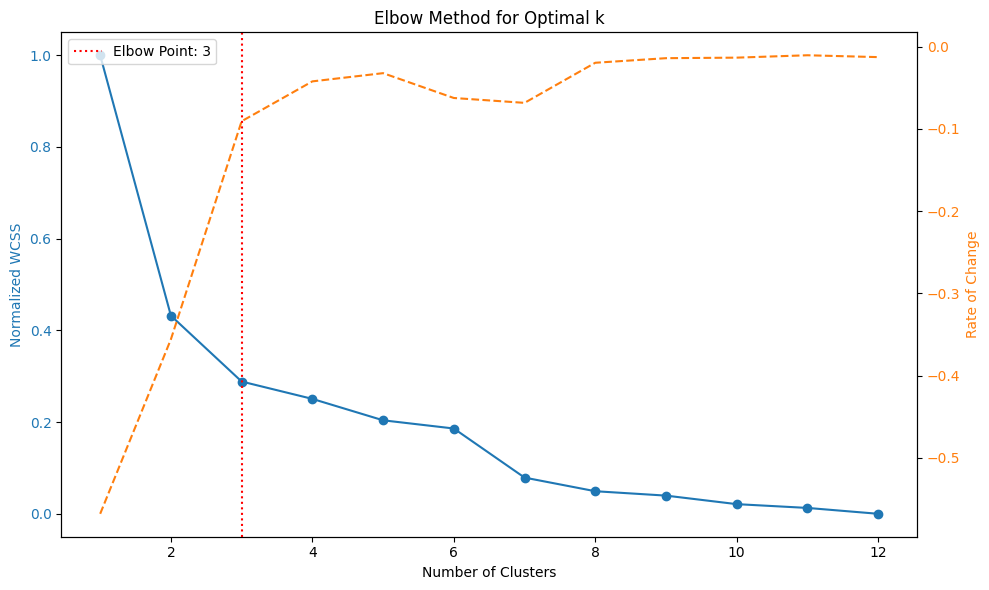

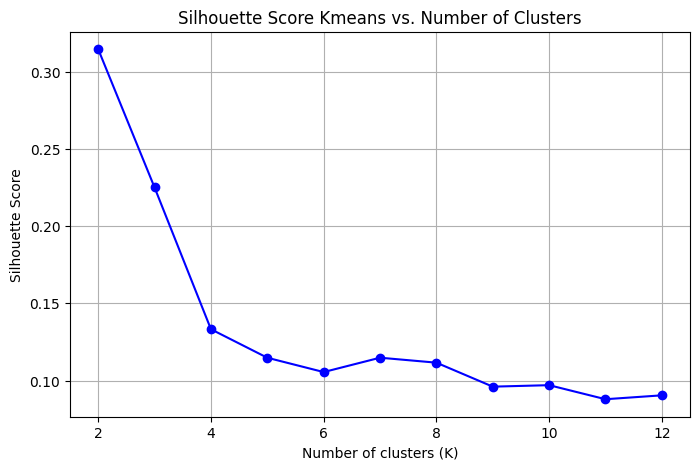

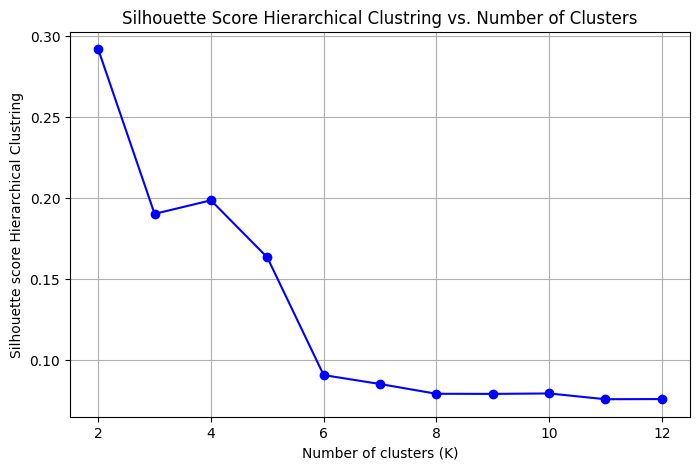

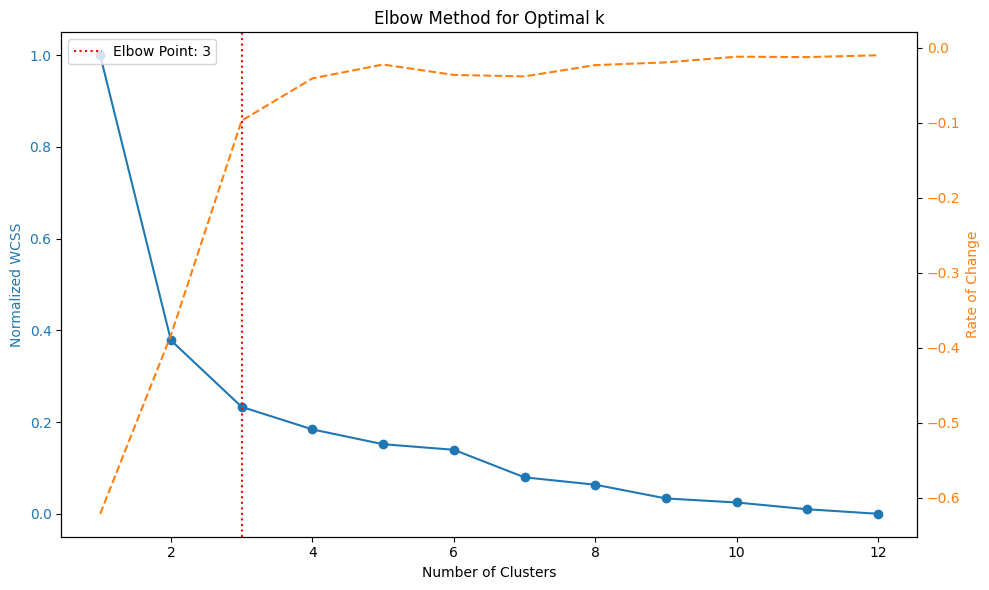

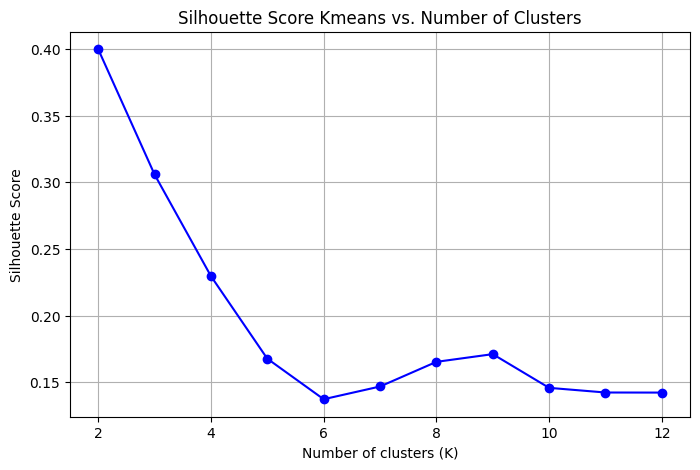

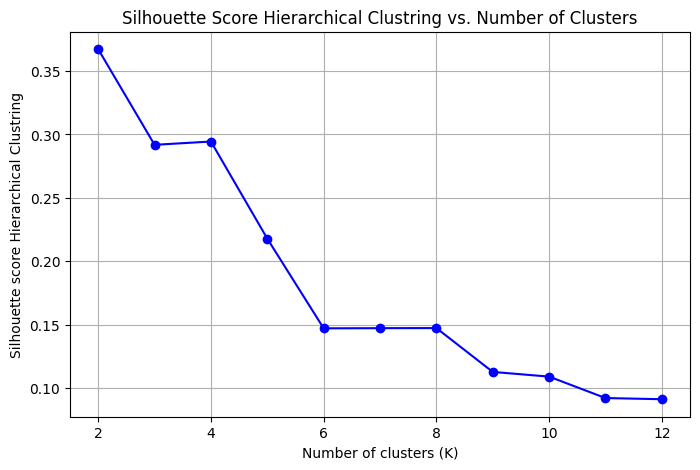

In [16]:
# Select features for clustering

# Determine the optimal number of clusters using the Elbow method and Silhouette Score.
    
for X in [X_scaled_df,X_pca_df]:
    
    wcss = []
    silhouette_scores = []
    silhouette_agg = []

    max_clusters = 12

    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        cluster_labels = kmeans.fit_predict(X)
        wcss.append(kmeans.inertia_)
        
        cluster = AgglomerativeClustering(n_clusters=k)
        agg_labels = cluster.fit_predict(X)
        
        if k == 1:
            continue # silhouette not valid when work with only one cluster, when k = 1
        # Calculate silhouette score
        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        
        silhouette_agg.append(silhouette_score(X, agg_labels))



    # Normalize WCSS
    wcss_normalized = [(w - min(wcss)) / (max(wcss) - min(wcss)) for w in wcss]

    # Calculate rate of change
    rate_of_change = np.gradient(wcss_normalized) 
    # Find the elbow point
    kn = KneeLocator(range(1, max_clusters + 1), wcss_normalized, curve='convex', direction='decreasing')
    elbow_point = kn.knee

    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot normalized WCSS
    color = 'tab:blue'
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Normalized WCSS', color=color)
    ax1.plot(range(1, max_clusters + 1), wcss_normalized, color=color, marker='o')
    ax1.tick_params(axis='y', labelcolor=color)

    # Plot rate of change on secondary axis
    ax2 = ax1.twinx()
    color = 'tab:orange'
    ax2.set_ylabel('Rate of Change', color=color)
    ax2.plot(range(1, max_clusters + 1), rate_of_change, color=color, linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)

    # Mark the elbow point
    plt.axvline(x=elbow_point, color='r', linestyle=':', label=f'Elbow Point: {elbow_point}')

    plt.title('Elbow Method for Optimal k')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Thanks for claude for this plot.



    # Plot the silhouette scores
    plt.figure(figsize=(8, 5))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, 'bo-')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score Kmeans vs. Number of Clusters')
    plt.grid(True)



    # Plot the silhouette scores
    plt.figure(figsize=(8, 5))
    plt.plot(range(2, max_clusters + 1), silhouette_agg, 'bo-')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Silhouette score Hierarchical Clustring')
    plt.title('Silhouette Score Hierarchical Clustring vs. Number of Clusters')
    plt.grid(True)

    plt.show()

In [17]:
# fit Kmeans on k = 3
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans_labels = kmeans.fit_predict(X_pca_df)

data['Kmeans_cluster'] = kmeans_labels
data['Kmeans_cluster'].value_counts()

Kmeans_cluster
0    789
1    662
2    572
Name: count, dtype: int64

In [18]:
# Perform Agglomerative Clustering 
cluster = AgglomerativeClustering(n_clusters=3)
agg_labels = cluster.fit_predict(X_pca_df)


In [19]:
print(f"Kmeans with k = 3 silhouette_score = {silhouette_score(X_pca_df, kmeans_labels)}")
print(f"Agglomerative with n_clusters = 3 silhouette_score = {silhouette_score(X_pca_df, agg_labels)}")

Kmeans with k = 3 silhouette_score = 0.3058896980430253
Agglomerative with n_clusters = 3 silhouette_score = 0.29180985118191866


> we will work with the PCA features.

> why i did PCA:
 - curse of dimensionality.
 - a try to capture the correlation between features.
 - avoid noise, make a robust clusters.

> why will i continue with pca result ?
 - more robust clusters.

###  Visualization

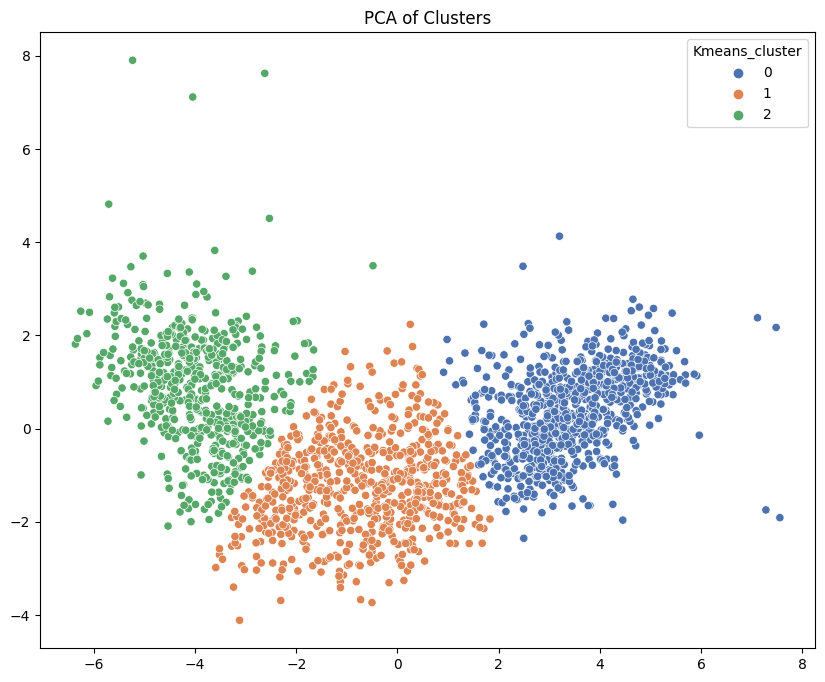

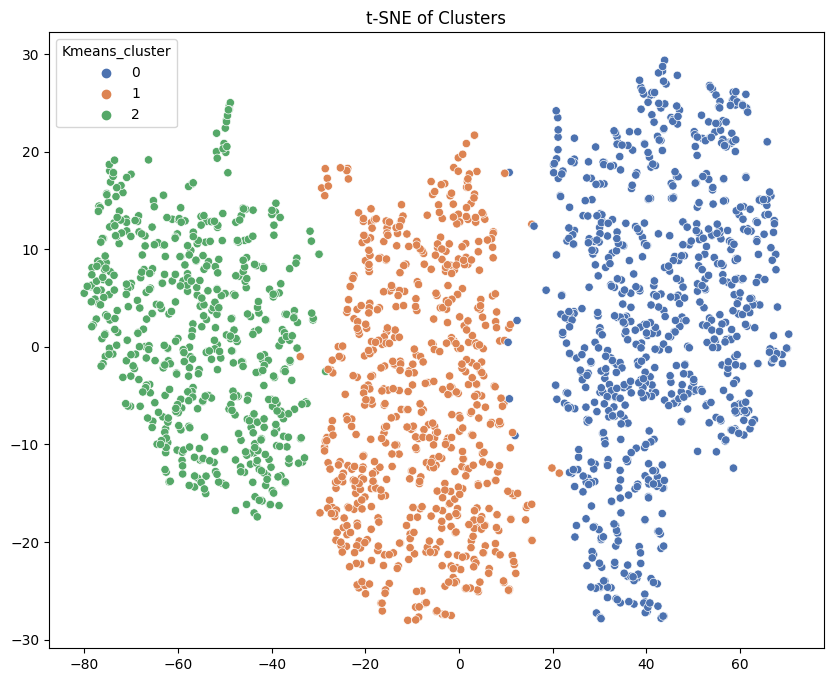

In [21]:
# PCA for dimensionality reduction for visualization in 2d
X = X_pca_df.copy()
X['Kmeans_cluster'] = data['Kmeans_cluster']

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=X['Kmeans_cluster'], palette='deep')
plt.title('PCA of Clusters')
plt.show()

# t-SNE visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(X)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=X['Kmeans_cluster'], palette='deep')
plt.title('t-SNE of Clusters')
plt.show()

### Cluster Profiling

In [22]:
# Select numeric columns
numeric_cols = data.select_dtypes(np.number).columns

# Calculate mean, median, and standard deviation for each feature in each cluster
cluster_profiles = data.groupby('Kmeans_cluster')[numeric_cols].agg(['mean', 'median', 'std'])

# Print the entire cluster profiles DataFrame
print("Cluster Profiles:\n", cluster_profiles.to_string())


Cluster Profiles:
                 MntWines                     MntFruits                     MntMeatProducts                     MntFishProducts                     MntSweetProducts                     MntGoldProds                     NumDealsPurchases                     NumWebPurchases                     NumCatalogPurchases                     NumStorePurchases                     NumWebVisitsMonth                            Income                           Recency                   AcceptedCmp3                  AcceptedCmp4                  AcceptedCmp5                  AcceptedCmp1                  AcceptedCmp2                   Complain                   Response                         Age                   Customer_Tenure                    total_Spent                      total_purchases                      Children                  Income_per_Person                            Campaign_Participation                  total_spent_per_time                     total_purchases_pe

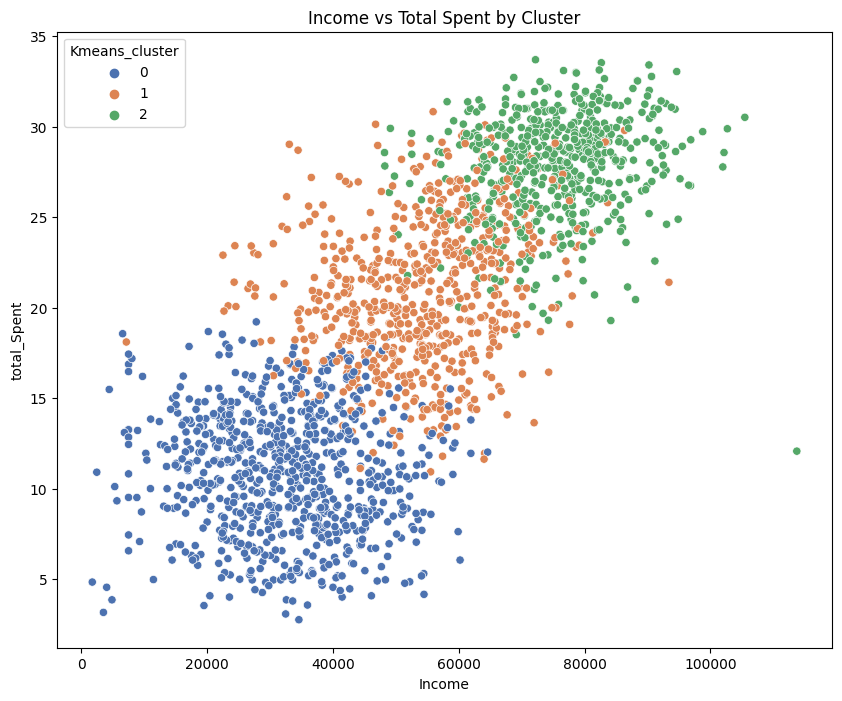

In [31]:
# fast look at a key features.
# Scatter plot of two key features
plt.figure(figsize=(10, 8))
sns.scatterplot(data=data, x='Income', y='total_Spent', hue='Kmeans_cluster', palette='deep')
plt.title('Income vs Total Spent by Cluster')
plt.show()


### Statistical Analysis

In [23]:
# Is there any significant difference in the feature means across all clusters?

anova_important_list = []

def anova_test(df, feature):
    groups = [group for _, group in df.groupby('Kmeans_cluster')[feature]]
    f_value, p_value = stats.f_oneway(*groups)
    return f_value, p_value

for column in numeric_cols:
    if column != 'Kmeans_cluster':
        f_value, p_value = anova_test(data, column)
        if p_value < 0.05:
            anova_important_list.append(column)
            print(f"ANOVA for {column}: F-value = {f_value:.2f}, p-value = {p_value:.4f}")

ANOVA for MntWines: F-value = 2863.24, p-value = 0.0000
ANOVA for MntFruits: F-value = 1001.17, p-value = 0.0000
ANOVA for MntMeatProducts: F-value = 3784.70, p-value = 0.0000
ANOVA for MntFishProducts: F-value = 1027.10, p-value = 0.0000
ANOVA for MntSweetProducts: F-value = 930.03, p-value = 0.0000
ANOVA for MntGoldProds: F-value = 673.85, p-value = 0.0000
ANOVA for NumDealsPurchases: F-value = 564.51, p-value = 0.0000
ANOVA for NumWebPurchases: F-value = 1303.47, p-value = 0.0000
ANOVA for NumCatalogPurchases: F-value = 2572.49, p-value = 0.0000
ANOVA for NumStorePurchases: F-value = 1586.03, p-value = 0.0000
ANOVA for NumWebVisitsMonth: F-value = 897.86, p-value = 0.0000
ANOVA for Income: F-value = 2588.87, p-value = 0.0000
ANOVA for AcceptedCmp4: F-value = 40.64, p-value = 0.0000
ANOVA for AcceptedCmp5: F-value = 200.08, p-value = 0.0000
ANOVA for AcceptedCmp1: F-value = 130.15, p-value = 0.0000
ANOVA for AcceptedCmp2: F-value = 9.41, p-value = 0.0001
ANOVA for Response: F-value =

In [24]:
# Identify distinguishing characteristics for each feature in each cluster and print the significant.
# t-test compare on one group vs rest

t_test_important = set()
for cluster in data['Kmeans_cluster'].unique():
    cluster_data = data[data['Kmeans_cluster'] == cluster]
    other_data = data[data['Kmeans_cluster'] != cluster]
    
    print(f"\nDistinguishing characteristics for Cluster {cluster}:")
    for column in numeric_cols:
        if column != 'Kmeans_cluster':
            t_stat, p_value = stats.ttest_ind(cluster_data[column], other_data[column])
            # Print t-statistic and p-value for all columns.
            #if p_value < 0.05:
                #t_test_important.add(column)
            print(f"{column}: t-statistic = {t_stat:.2f}, p-value = {p_value:.4f}")



Distinguishing characteristics for Cluster 2:
MntWines: t-statistic = 28.71, p-value = 0.0000
MntFruits: t-statistic = 35.98, p-value = 0.0000
MntMeatProducts: t-statistic = 44.50, p-value = 0.0000
MntFishProducts: t-statistic = 36.62, p-value = 0.0000
MntSweetProducts: t-statistic = 35.49, p-value = 0.0000
MntGoldProds: t-statistic = 20.48, p-value = 0.0000
NumDealsPurchases: t-statistic = -21.28, p-value = 0.0000
NumWebPurchases: t-statistic = 15.37, p-value = 0.0000
NumCatalogPurchases: t-statistic = 41.01, p-value = 0.0000
NumStorePurchases: t-statistic = 26.81, p-value = 0.0000
NumWebVisitsMonth: t-statistic = -42.02, p-value = 0.0000
Income: t-statistic = 47.01, p-value = 0.0000
Recency: t-statistic = 0.32, p-value = 0.7454
AcceptedCmp3: t-statistic = 0.06, p-value = 0.9543
AcceptedCmp4: t-statistic = 5.07, p-value = 0.0000
AcceptedCmp5: t-statistic = 19.97, p-value = 0.0000
AcceptedCmp1: t-statistic = 15.93, p-value = 0.0000
AcceptedCmp2: t-statistic = 3.80, p-value = 0.0001
Co

In [25]:
print(len(anova_important_list) == len(t_test_important))

# any one appear in one and not in the second ?
diff = [True if col in t_test_important and col not in anova_important_list else False for col in t_test_important]
print(f"count of features appear in t-test and not in anova = {sum(diff)}")

False
count of features appear in t-test and not in anova = 0


In [26]:
# the most significant features
print(anova_important_list)

['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Income', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Response', 'Age', 'Customer_Tenure', 'total_Spent', 'total_purchases', 'Children', 'Income_per_Person', 'Campaign_Participation', 'total_spent_per_time', 'total_purchases_per_time']


### how much every feature is important for all and for every cluster ?

Accuracy: 0.97


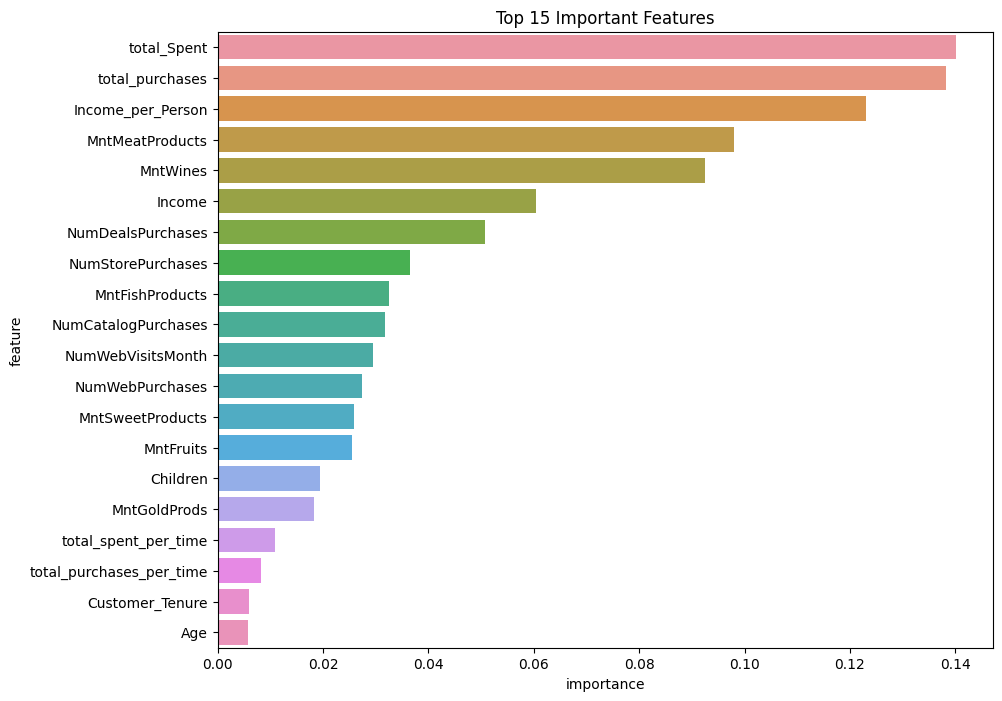

In [27]:
# Feature Importance:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

df['Kmeans_cluster'] = data['Kmeans_cluster']  # the df is one hot encoded

X = df.drop(['Kmeans_cluster'], axis = 1)
y = df['Kmeans_cluster']

rf = RandomForestClassifier(n_estimators=100, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf.fit(X_train, y_train)

feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Evaluate the model
# Predictions
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 15 Important Features')
plt.show()

Processing cluster 2 vs. rest...
Cluster 2 Accuracy: 0.98


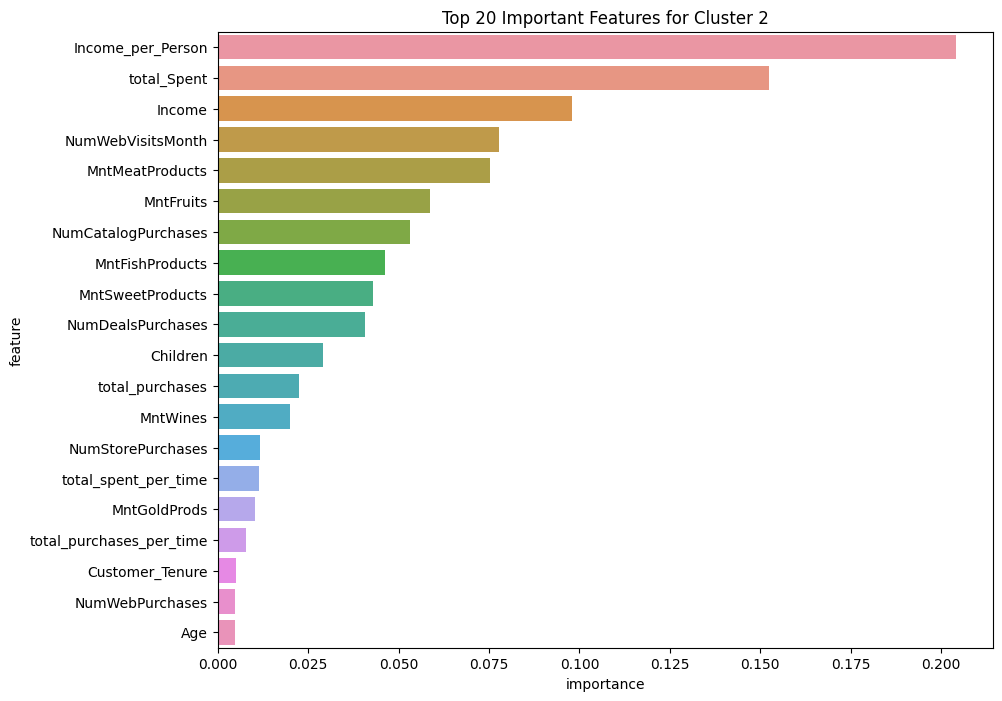

Processing cluster 0 vs. rest...
Cluster 0 Accuracy: 0.99


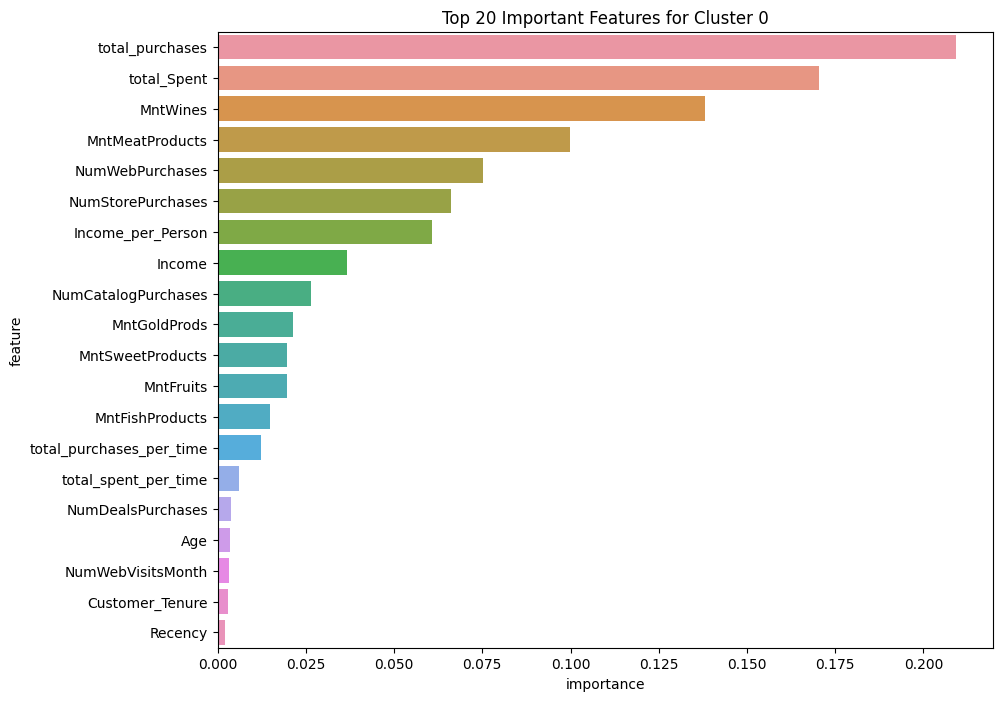

Processing cluster 1 vs. rest...
Cluster 1 Accuracy: 0.98


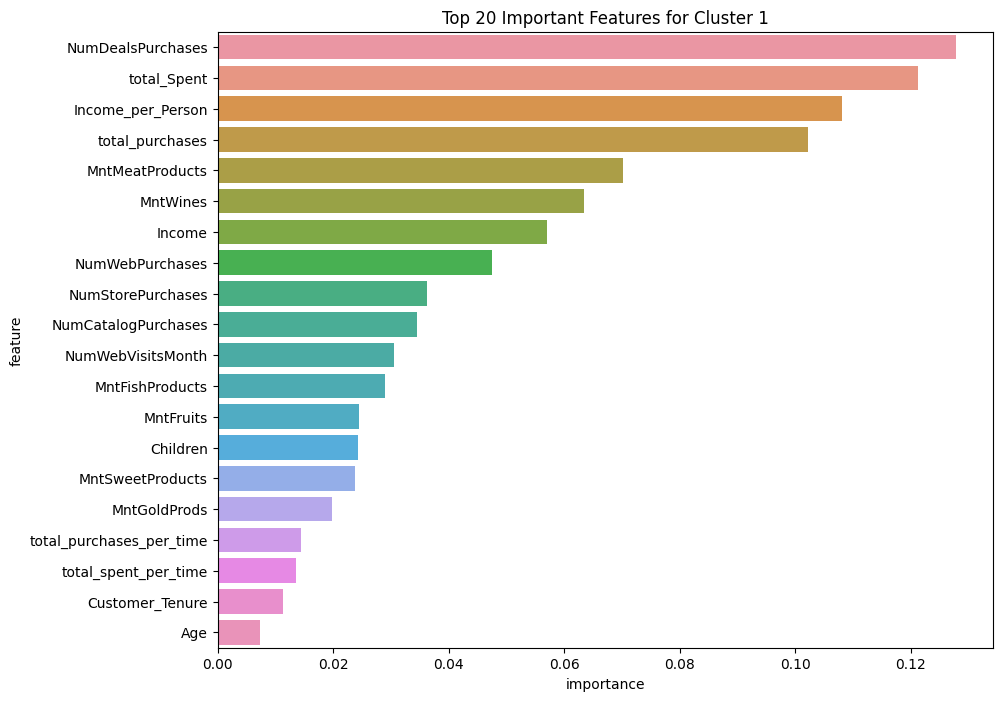

In [28]:
# for every cluster

for cluster in df['Kmeans_cluster'].unique():
    print(f"Processing cluster {cluster} vs. rest...")
    
    X = df.drop(['Kmeans_cluster'], axis=1)
    y = (df['Kmeans_cluster'] == cluster).astype(int) # true = 1, false = 0 --> binary classifier
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    rf.fit(X_train, y_train)
    
    feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    # Evaluate the model
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Cluster {cluster} Accuracy: {accuracy:.2f}')
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
    plt.title(f'Top 20 Important Features for Cluster {cluster}')
    plt.show()

### some Customer Segmentation Analysis


In [32]:
df.columns

Index(['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
       'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'Income', 'Recency', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response', 'Age', 'Customer_Tenure', 'total_Spent',
       'total_purchases', 'Children', 'Income_per_Person',
       'Campaign_Participation', 'total_spent_per_time',
       'total_purchases_per_time', '2n_Cycle', 'Basic', 'Graduation', 'Master',
       'PhD', 'Divorced', 'Married', 'Single', 'Together', 'Widow',
       'Very_Recent', 'Recent', 'Not_Recent', 'Long_Time', 'Kmeans_cluster'],
      dtype='object')

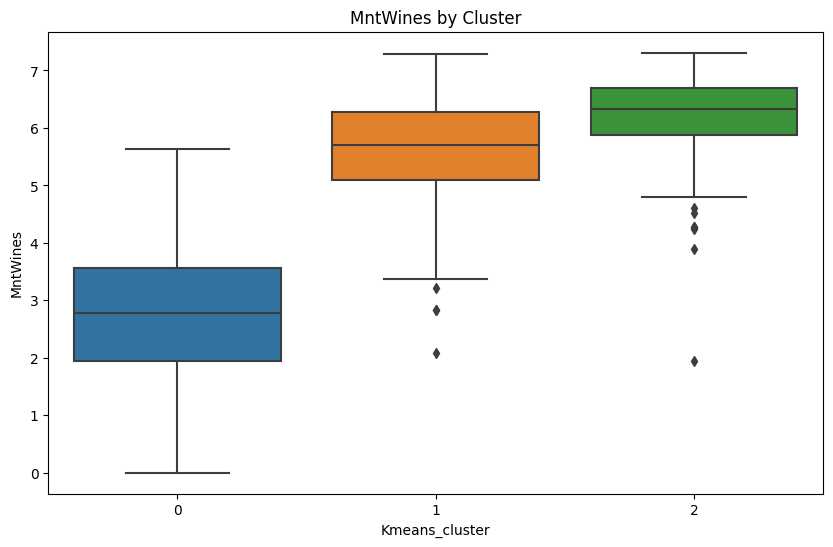

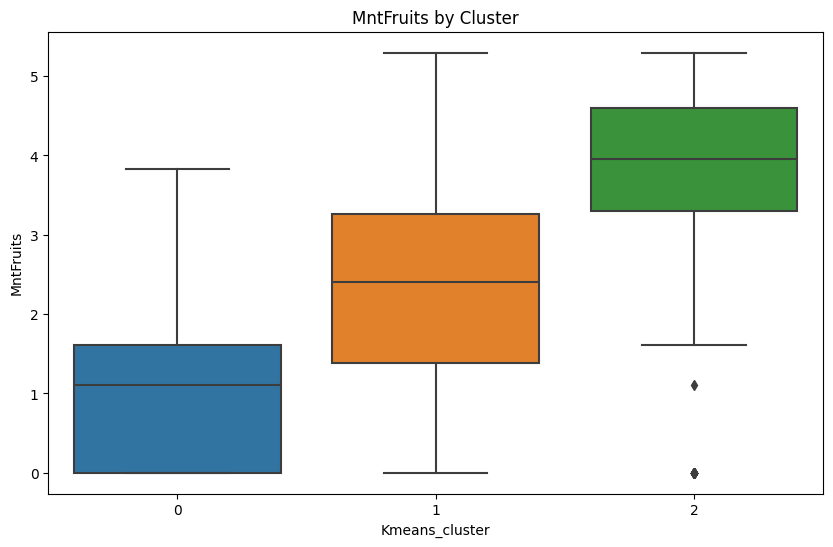

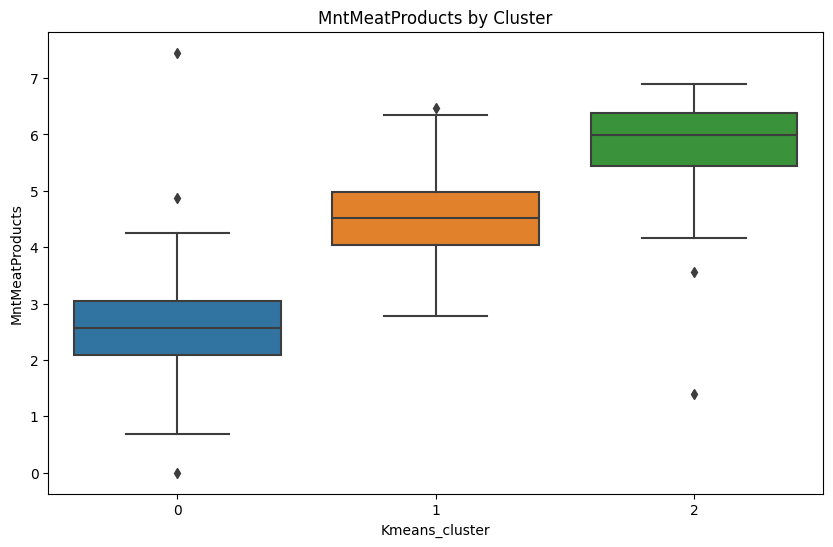

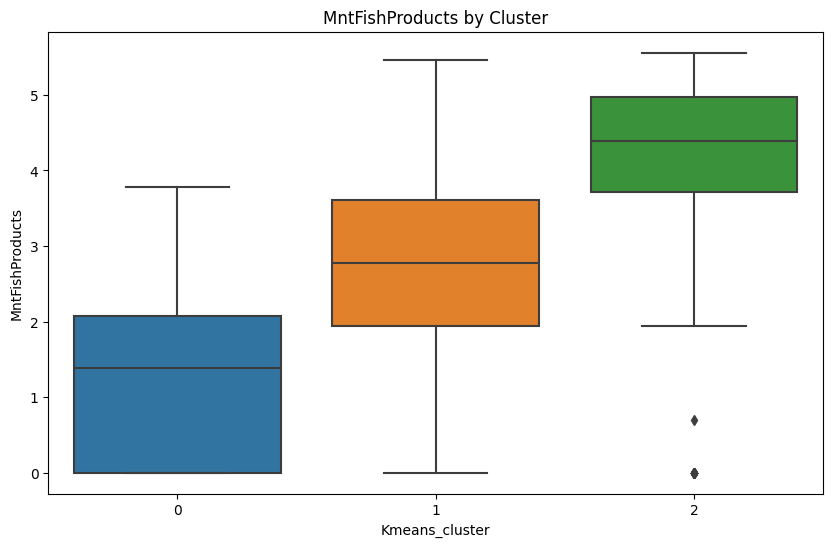

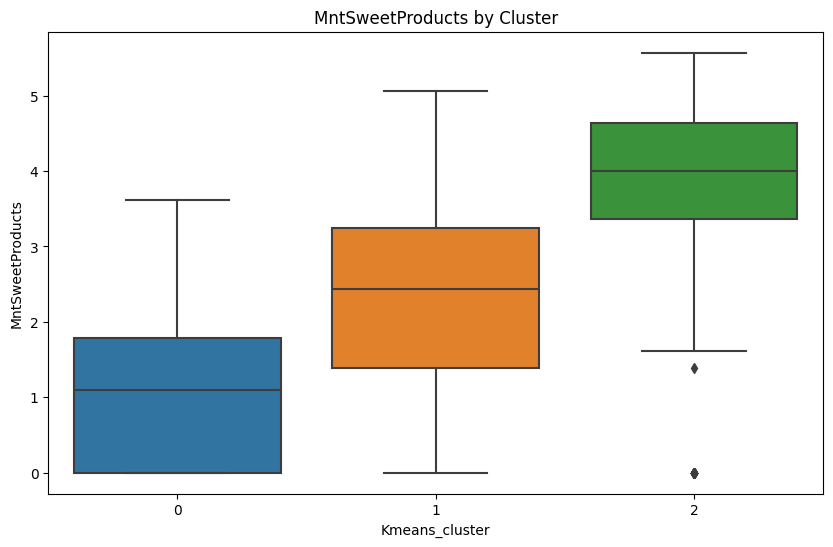

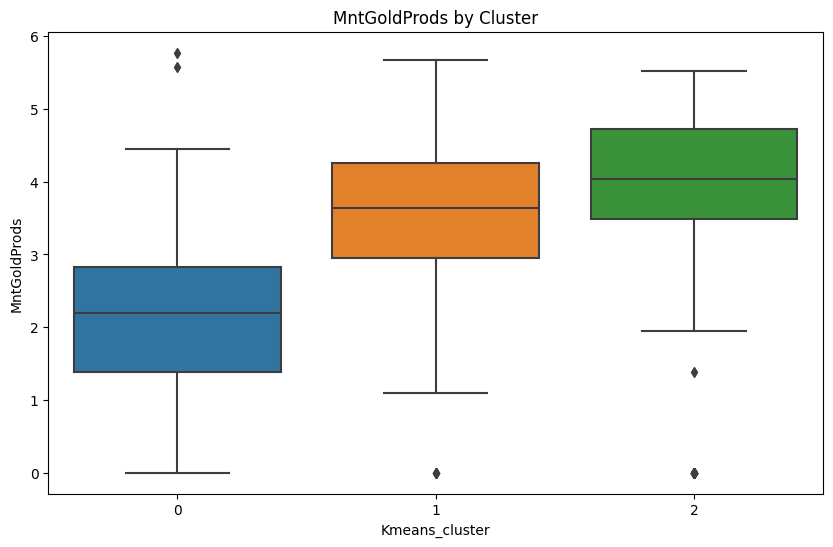

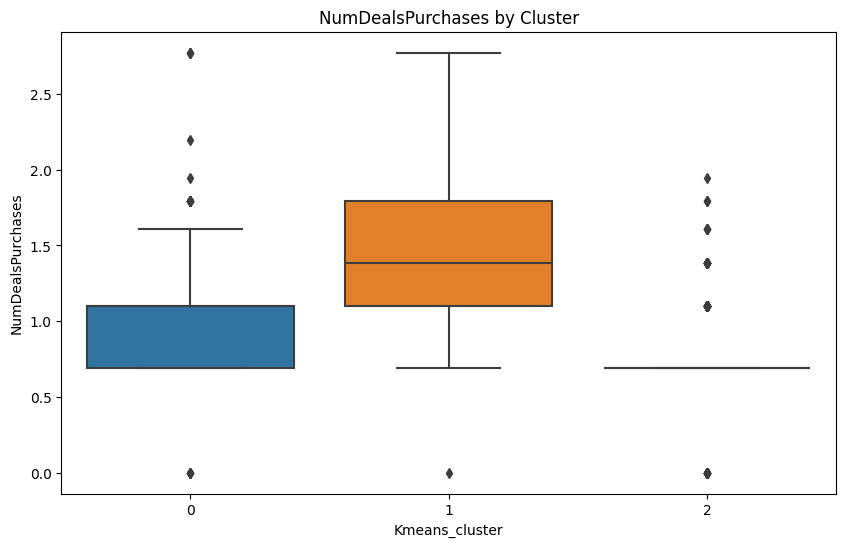

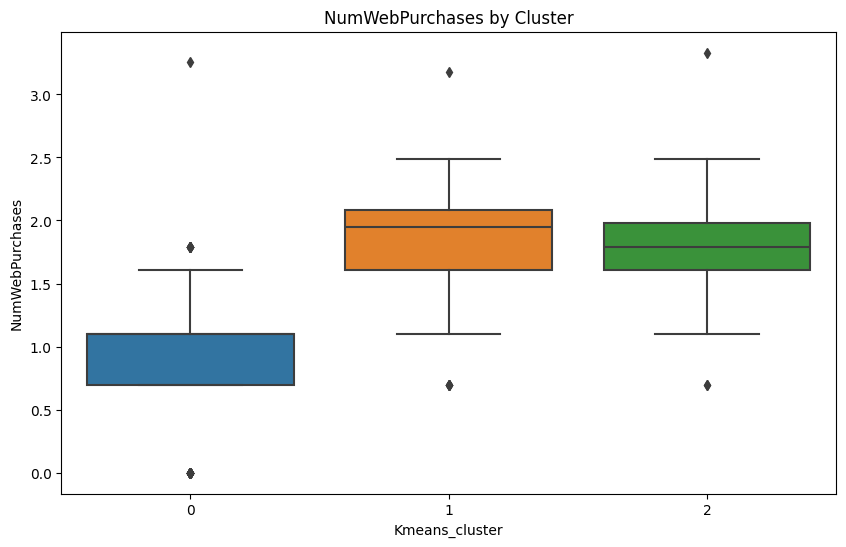

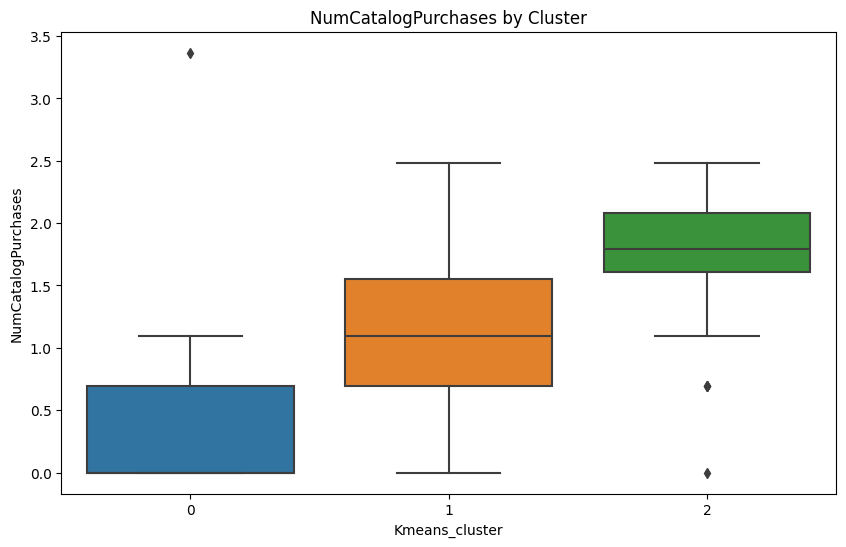

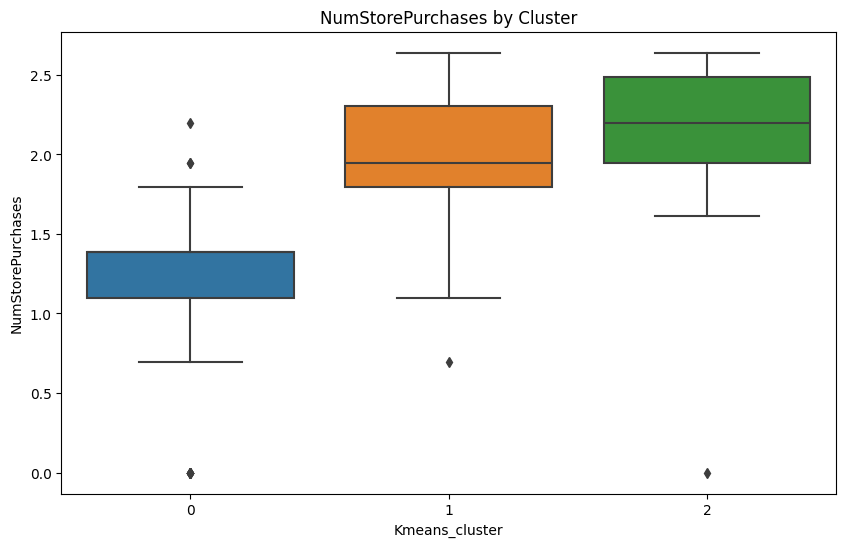

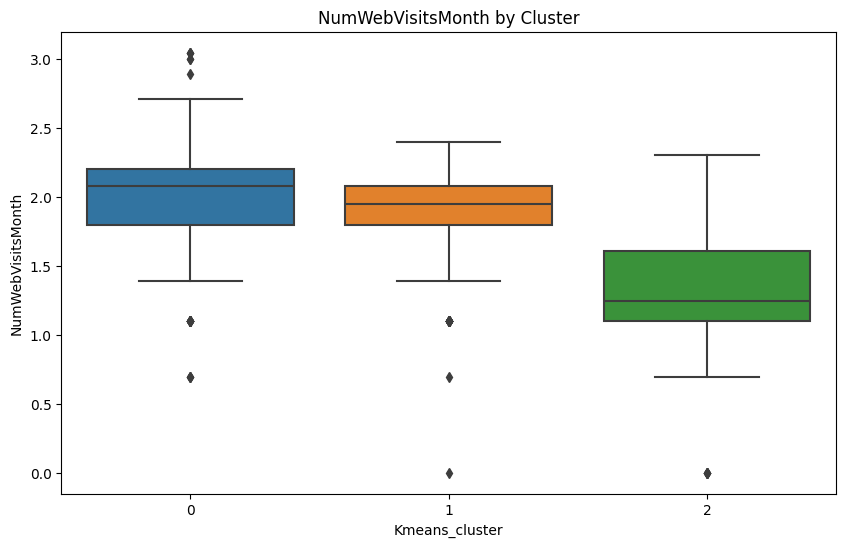

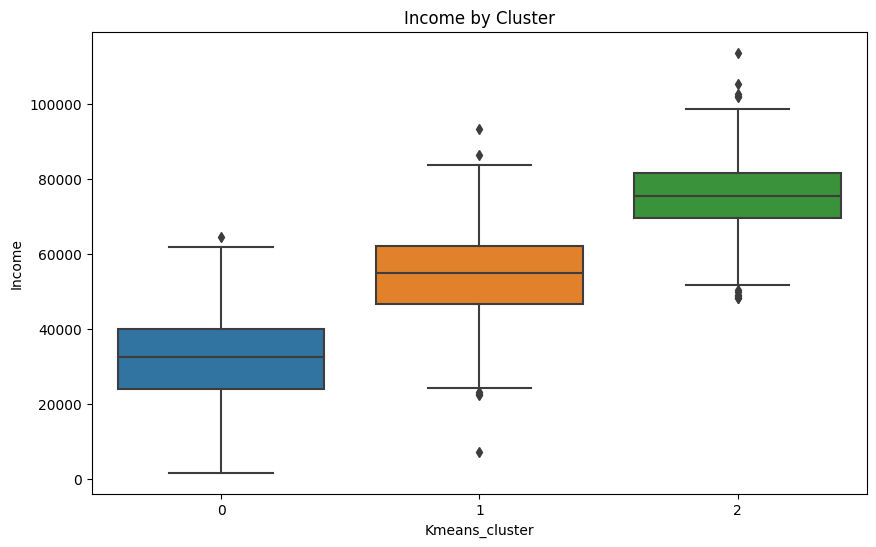

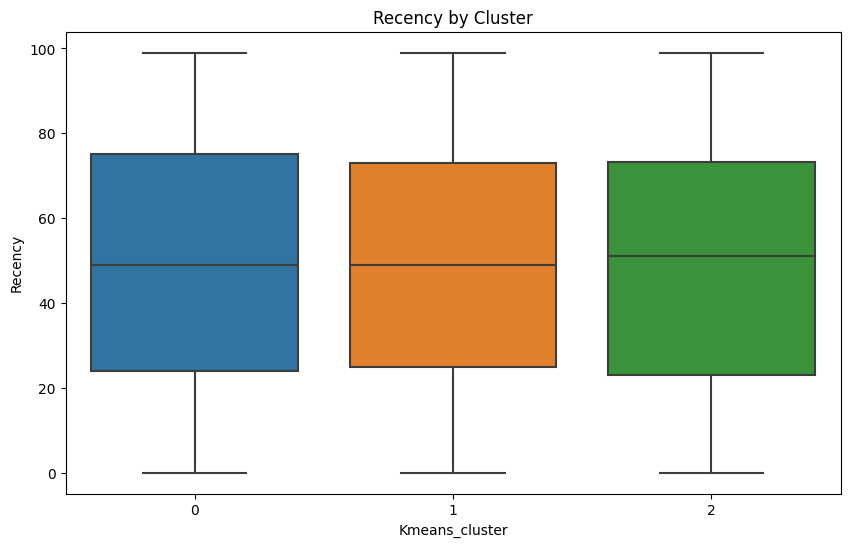

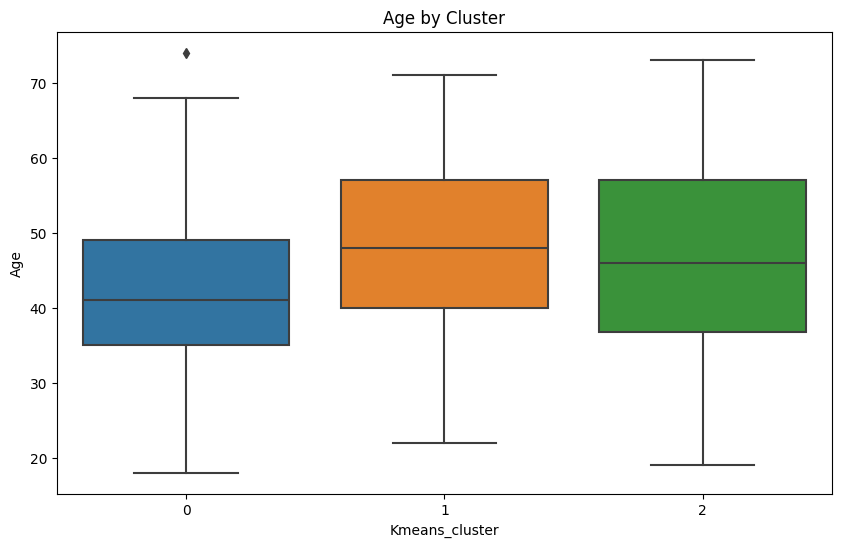

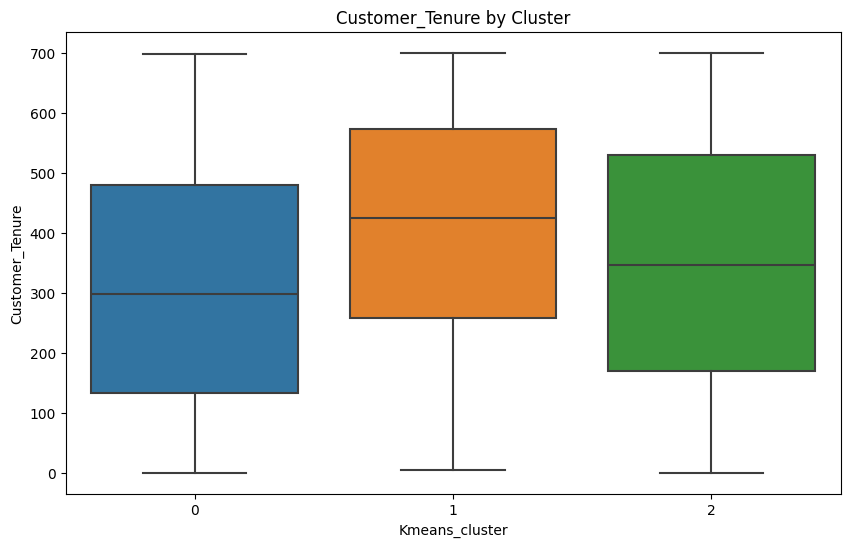

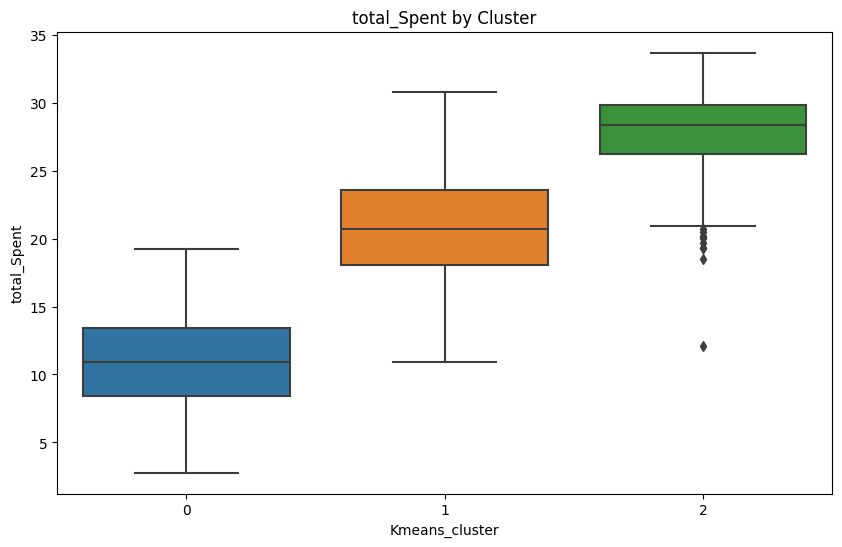

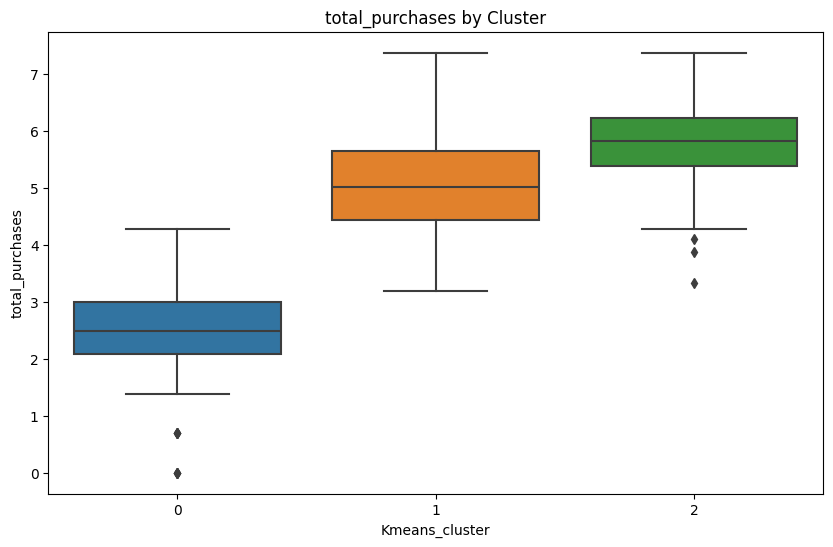

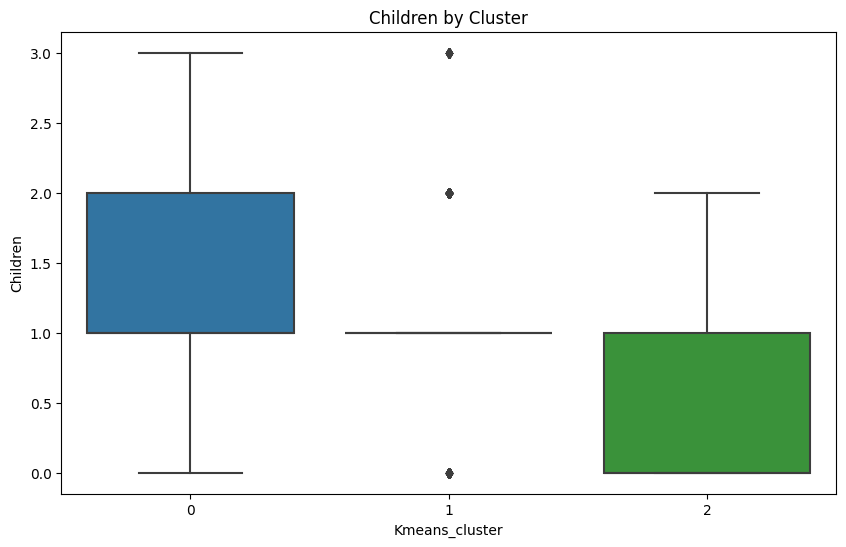

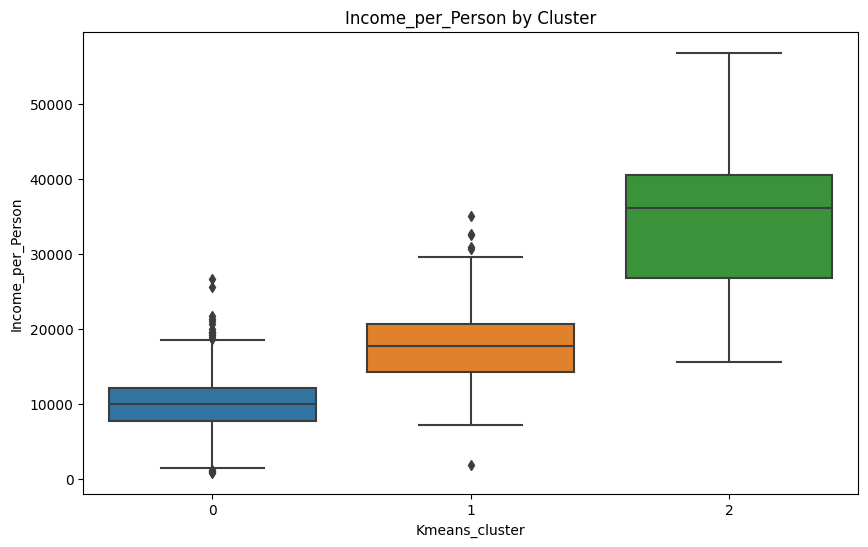

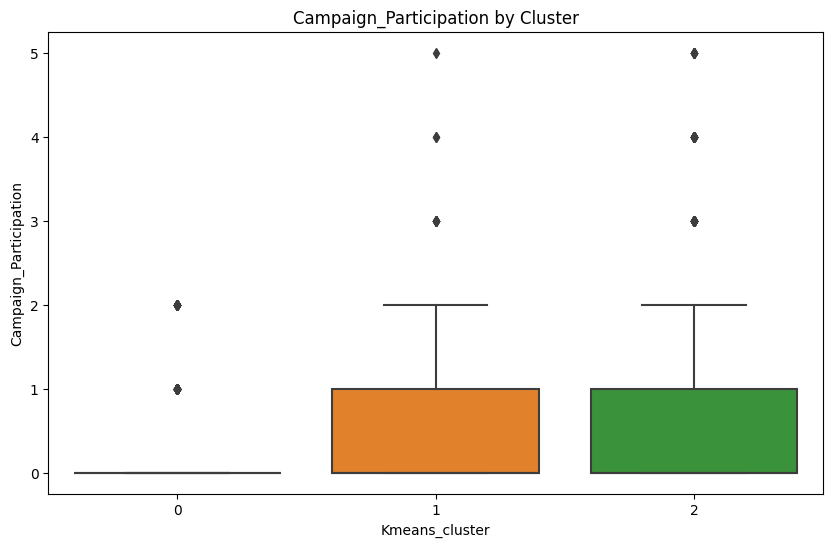

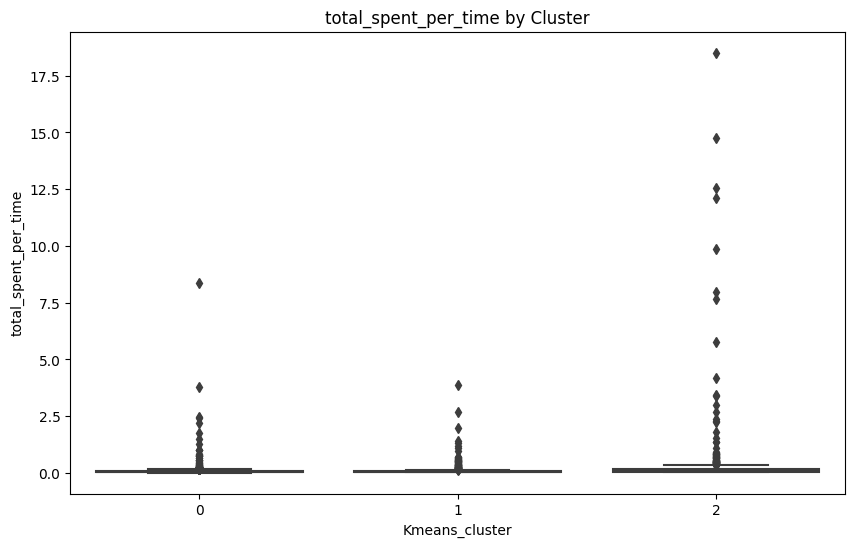

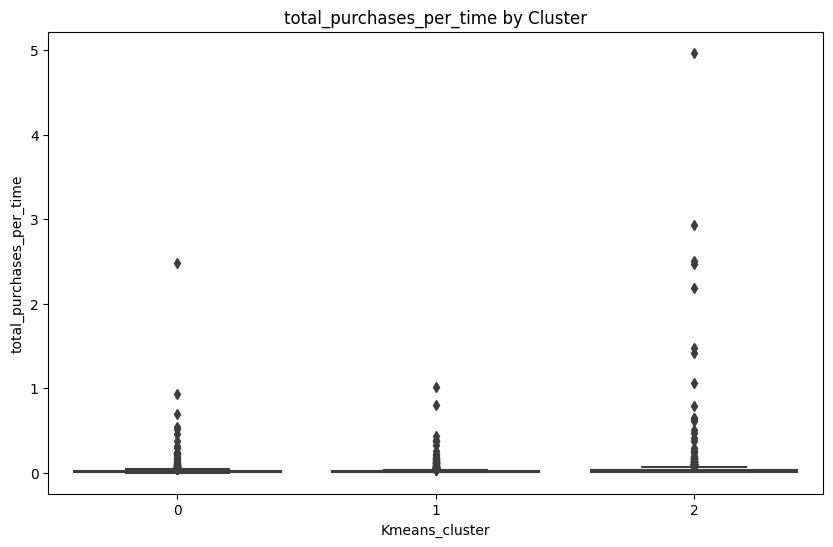

In [43]:

# Separate binary and non-binary columns
non_binary_cols = [col for col in df.columns if df[col].nunique() > 2]

# remove cluster from being plotted
non_binary_cols.remove('Kmeans_cluster')

# Plot the remaining columns by cluster
for var in non_binary_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Kmeans_cluster', y=var, data=df)
    plt.title(f'{var} by Cluster')
    plt.show()


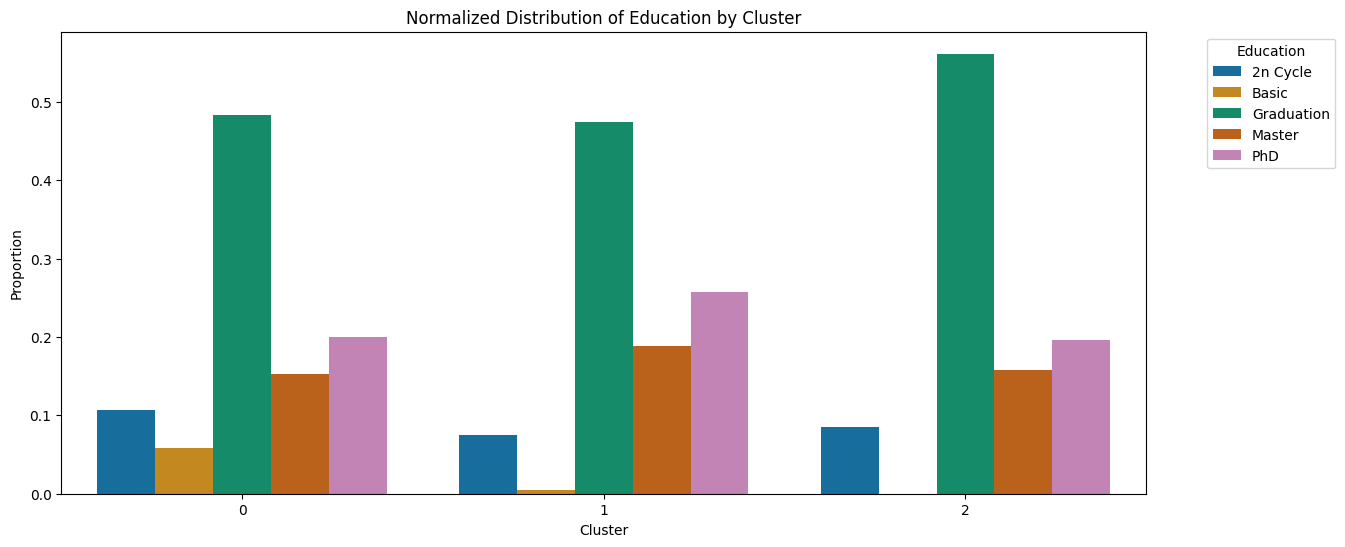

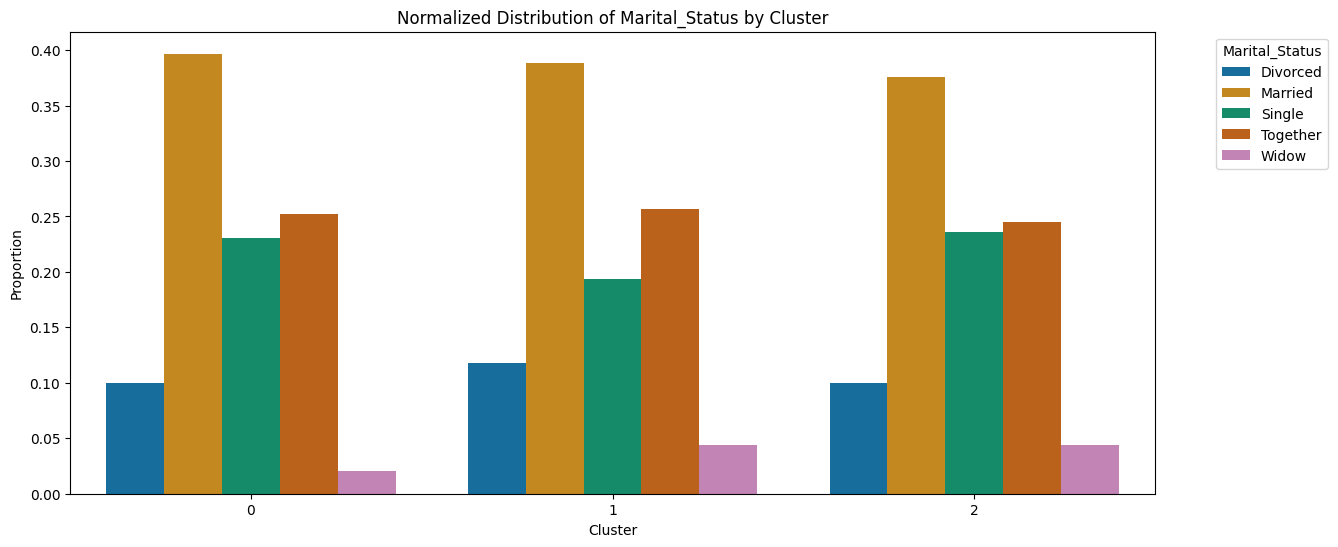

/tmp/ipykernel_156693/670806927.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  normalized_df = data.groupby(['Kmeans_cluster', cat_var]).size().reset_index(name='Count')


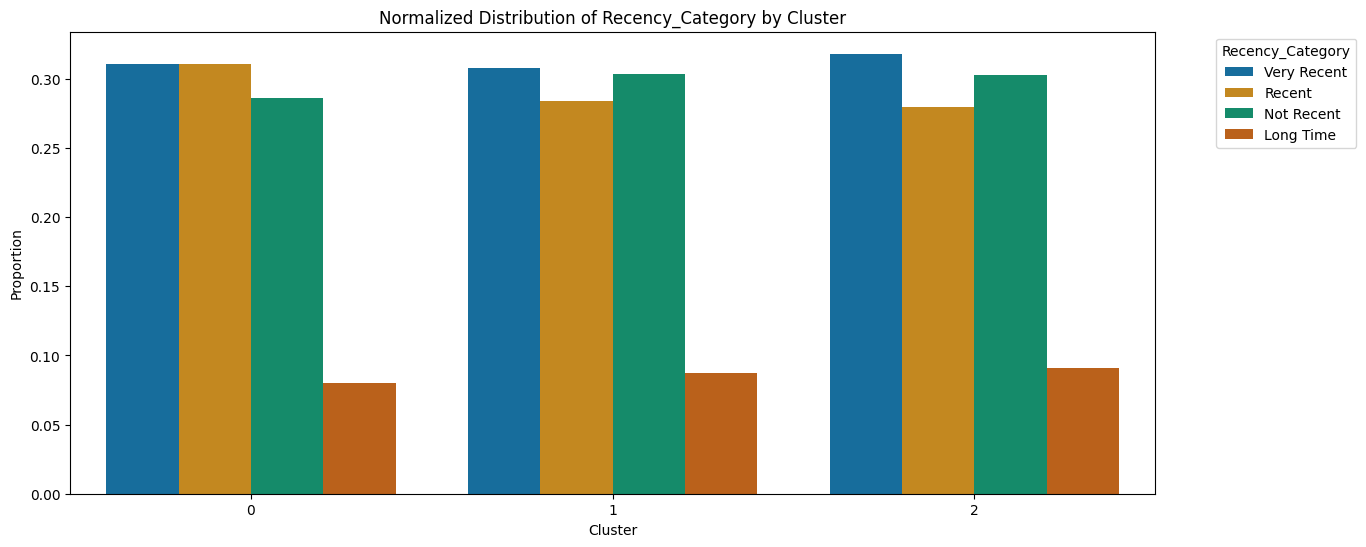

In [68]:
# Plot binary columns separately by cluster
cat_cols = ['Education','Marital_Status','Recency_Category',]

# Plot normalized count plots for categorical columns by cluster
for cat_var in cat_cols:
    # Create a DataFrame to store normalized counts
    normalized_df = data.groupby(['Kmeans_cluster', cat_var]).size().reset_index(name='Count')
    
    # Calculate total counts per cluster
    cluster_sizes = data['Kmeans_cluster'].value_counts().to_dict()
    
    # Normalize the counts by cluster size
    normalized_df['Proportion'] = normalized_df.apply(lambda row: row['Count'] / cluster_sizes[row['Kmeans_cluster']], axis=1)

    # Plot the normalized proportions using countplot
    plt.figure(figsize=(14, 6))
    sns.barplot(x='Kmeans_cluster', y='Proportion', hue=cat_var, data=normalized_df, palette='colorblind')
    
    plt.title(f'Normalized Distribution of {cat_var} by Cluster')
    plt.ylabel('Proportion')
    plt.xlabel('Cluster')
    plt.legend(title=cat_var, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


### Campaign Performance Analysis


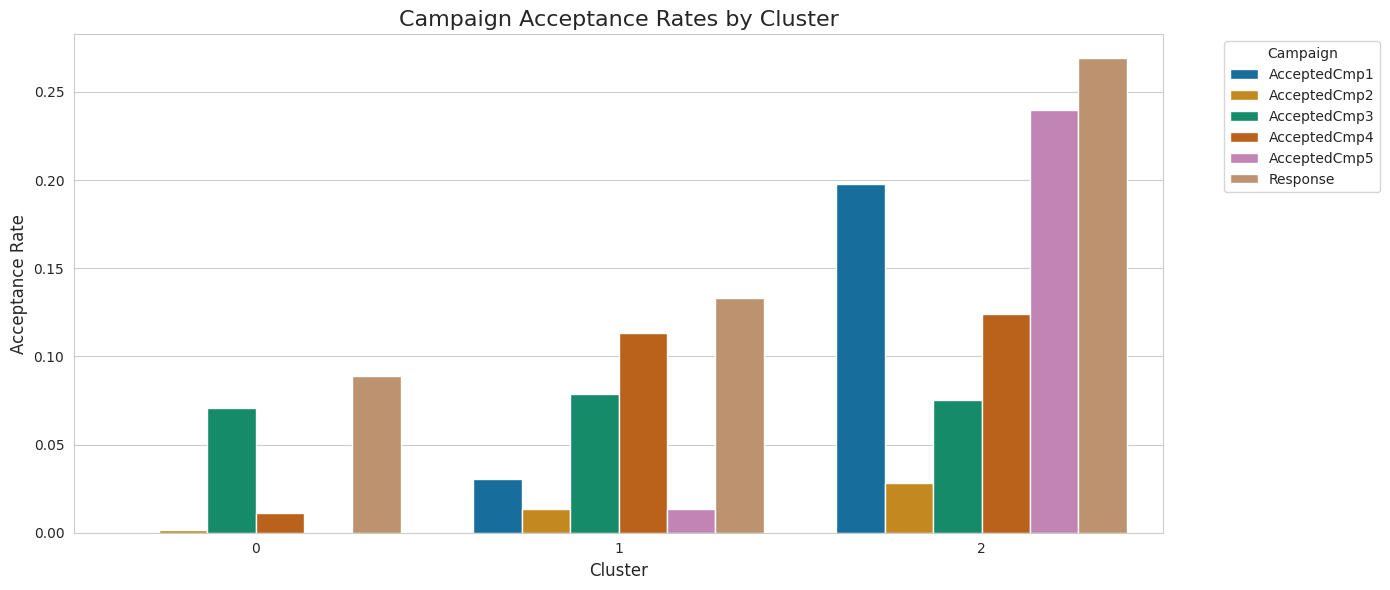

In [80]:
campaign_vars = ['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Response']

# Set the style for Seaborn
sns.set_style("whitegrid")

# Create the figure and axes
plt.figure(figsize=(14, 6))

# Create the grouped bar plot
sns.barplot(data=campaign_performance.reset_index().melt(id_vars='Kmeans_cluster'),
            x='Kmeans_cluster', y='value', hue='variable',palette='colorblind')

# Customize the plot
plt.title('Campaign Acceptance Rates by Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Acceptance Rate', fontsize=12)
plt.legend(title='Campaign', bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate x-axis labels if needed
plt.xticks(rotation=0)

# Adjust layout to prevent cutting off the legend
plt.tight_layout()

# Show the plot
plt.show()